# Step 1: LLM Inference

In [1]:
import os
import pandas as pd
import json
from huggingface_hub import InferenceClient

/Users/ChrisKarg/.pyenv/versions/axa_llm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess_text(raw_text):
    """
    Preprocess the raw text by adding line breaks before speaker identifiers.
    
    Parameters:
        raw_text (str): The raw conversation transcript.

    Returns:
        str: Formatted text with proper line breaks.
    """
    formatted_text = raw_text.strip()
    formatted_text = formatted_text.replace("PA Agent:", "\n\nPA Agent:").replace("Member:", "\n\nMember:").strip()
    if not formatted_text.startswith("\n"):
        formatted_text = "\n" + formatted_text
    return formatted_text

In [3]:
def load_transcripts_to_df(data_folder):
    """
    Reads all transcript_x.txt files from a specified folder into a DataFrame.
    
    Parameters:
        data_folder (str): Path to the folder containing transcript files.

    Returns:
        pd.DataFrame: A DataFrame containing file name, raw text, and empty columns for sentiment, follow-up_needed, and tag.
    """
    # Initialize list to hold file data
    data = []
    
    for file_name in os.listdir(data_folder):
        # Check if the file matches the 'transcript_x.txt' format
        if file_name.startswith("transcript_") and file_name.endswith(".txt"):
            file_path = os.path.join(data_folder, file_name)
            
            try:
                # Read file
                with open(file_path, 'r', encoding='utf-8') as file:
                    raw_text = file.read().strip()
                    formatted_text = preprocess_text(raw_text)
                
                # Append file
                data.append({
                    'name': file_name,
                    'raw': formatted_text,
                    'sentiment': '',
                    'follow_up_needed': '',
                    'tag': ''
                })
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
                
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(data, columns=['name', 'raw', 'sentiment', 'follow_up_needed', 'tag'])
    return df

In [4]:
data_folder = "../data"
df = load_transcripts_to_df(data_folder)
df.head()

,name,raw,sentiment,follow_up_needed,tag
0,transcript_38.txt,"\nMember: Hi, I'm calling to get a case pre-au...",,,
1,transcript_10.txt,"\nMember: Hi, I'm calling to schedule an appoi...",,,
2,transcript_138.txt,"\nMember: Hi, I'm calling to get a case pre-au...",,,
3,transcript_104.txt,"\nMember: Hi, I'm calling to get a case pre-au...",,,
4,transcript_110.txt,"\nMember: Hi, I'm calling about a denied claim...",,,


In [5]:
print(repr(df.loc[0, 'raw']))

"\nMember: Hi, I'm calling to get a case pre-authorized for a medical procedure. My name is Emily Wilson and my member ID is MEM456789.\n\n\n\nPA Agent: Thank you for calling, Emily. Can you please confirm your date of birth and the procedure you're seeking pre-authorization for?\n\n\n\nMember: My date of birth is March 12, 1985, and I'm looking to get pre-authorization for a knee replacement surgery.\n\n\n\nPA Agent: Okay, thank you for providing that information, Emily. Can you please tell me a little bit more about the procedure and why it's needed?\n\n\n\nMember: Sure. I've been experiencing chronic knee pain for several years and my doctor has recommended a knee replacement surgery to alleviate the pain and improve my mobility.\n\n\n\nPA Agent: I understand. Can you please provide me with your doctor's name and contact information so I can verify the details?\n\n\n\nMember: My doctor's name is Dr. John Smith and his office number is 555-1234.\n\n\n\nPA Agent: Thank you, Emily. I'm

In [6]:
df.shape

(199, 5)

In [7]:
df

,name,raw,sentiment,follow_up_needed,tag
0,transcript_38.txt,"\nMember: Hi, I'm calling to get a case pre-au...",,,
1,transcript_10.txt,"\nMember: Hi, I'm calling to schedule an appoi...",,,
2,transcript_138.txt,"\nMember: Hi, I'm calling to get a case pre-au...",,,
3,transcript_104.txt,"\nMember: Hi, I'm calling to get a case pre-au...",,,
4,transcript_110.txt,"\nMember: Hi, I'm calling about a denied claim...",,,
...,...,...,...,...,...
194,transcript_135.txt,"\nMember: Hi, I'm calling about a denied claim...",,,
195,transcript_121.txt,"\nMember: Hi, I'm calling to get a case pre-au...",,,
196,transcript_0.txt,"\nMember: Hi, I'm calling to get a case pre-au...",,,
197,transcript_35.txt,"\nMember: Hi, I'm having trouble logging in to...",,,


In [8]:
df.iloc[84]

name                                                transcript_52.txt
raw                 \nMember: Hi, I'm calling to schedule an appoi...
sentiment                                                            
follow_up_needed                                                     
tag                                                                  
Name: 84, dtype: object

In [9]:
df = df.drop(index=84).reset_index(drop=True)

In [10]:
def run_llm_inference(df):
    """
    Runs inference using HuggingFace LLM on the raw text and updates sentiment, follow-up_needed, and tag columns.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the transcript data.

    Returns:
        pd.DataFrame: Updated DataFrame with inference results.
    """
    client = InferenceClient(api_key="?????")
    processed_count = 0 

    for idx, row in df.iterrows():
        messages = [
            {"role": "system", "content": "You are expert customer service agent. You are to decide the customer sentiment in their conversation with a PA agent. The sentiment can only be one of three categories - positive, negative, neutral. You are also to decide if the issue is resolved or if a follow-up action is needed.  Please also tag the conversation with one of three tags - either \"claim\" if the call is about a claim, \"policy\" if it is a question about the insurance policy, \"tech\" if it is about not being able to log in to online services, \"pre-auth\" if a member wants a treatment authorised, or \"other\" if the call cannot be categorised. Please provide the answer in dictionary format eg {\"sentiment\": \"neutral\", \"follow_up_needed\": \"yes\", \"tag\": \"claim\"}. Please only provide the dictionary response and no explanation."},
            {"role": "user", "content": f"Here is the conversation transcript:\n{row['raw']}"}
        ]

        try:
            # Run inference
            stream = client.chat.completions.create(
                model="mistralai/Mistral-Nemo-Instruct-2407",
                messages=messages,
                temperature=0.5,
                max_tokens=2048,
                top_p=0.7,
                stream=True
            )
            response_content = ""
            for chunk in stream:
                if chunk.choices[0].delta.content:
                    response_content += chunk.choices[0].delta.content
            
            # Parse response safely as JSON
            try:
                result = json.loads(response_content)
                df.at[idx, 'sentiment'] = result.get('sentiment', 'unknown')
                df.at[idx, 'follow_up_needed'] = result.get('follow_up_needed', 'unknown')
                df.at[idx, 'tag'] = result.get('tag', 'unknown')
            except json.JSONDecodeError:
                print(f"Invalid JSON response for row {idx}: {response_content}")
                # Handle invalid response by assigning default values
                df.at[idx, 'sentiment'] = 'unknown'
                df.at[idx, 'follow_up_needed'] = 'unknown'
                df.at[idx, 'tag'] = 'unknown'
        except Exception as e:
            print(f"Error running inference on row {idx}: {e}")

        processed_count += 1
        print(f"Processed rows: {processed_count}/{len(df)}")
    
    return df

In [11]:
df = run_llm_inference(df)

Processed rows: 1/198
Processed rows: 2/198
Processed rows: 3/198
Processed rows: 4/198
Processed rows: 5/198
Processed rows: 6/198
Processed rows: 7/198
Processed rows: 8/198
Processed rows: 9/198
Processed rows: 10/198
Processed rows: 11/198
Processed rows: 12/198
Processed rows: 13/198
Processed rows: 14/198
Processed rows: 15/198
Processed rows: 16/198
Processed rows: 17/198
Processed rows: 18/198
Processed rows: 19/198
Processed rows: 20/198
Processed rows: 21/198
Processed rows: 22/198
Processed rows: 23/198
Processed rows: 24/198
Processed rows: 25/198
Processed rows: 26/198
Processed rows: 27/198
Processed rows: 28/198
Processed rows: 29/198
Processed rows: 30/198
Processed rows: 31/198
Processed rows: 32/198
Processed rows: 33/198
Processed rows: 34/198
Processed rows: 35/198
Processed rows: 36/198
Processed rows: 37/198
Processed rows: 38/198
Processed rows: 39/198
Processed rows: 40/198
Processed rows: 41/198
Processed rows: 42/198
Processed rows: 43/198
Processed rows: 44/1

In [12]:
df.head()

,name,raw,sentiment,follow_up_needed,tag
0,transcript_38.txt,"\nMember: Hi, I'm calling to get a case pre-au...",positive,no,pre-auth
1,transcript_10.txt,"\nMember: Hi, I'm calling to schedule an appoi...",positive,no,pre-auth
2,transcript_138.txt,"\nMember: Hi, I'm calling to get a case pre-au...",positive,yes,pre-auth
3,transcript_104.txt,"\nMember: Hi, I'm calling to get a case pre-au...",neutral,yes,pre-auth
4,transcript_110.txt,"\nMember: Hi, I'm calling about a denied claim...",neutral,yes,claim


# Step 2: Straightforward Accuracy Metric

* Create test set with 40 hand labelled examples (20% of dataset)
* Compare LLM output to hand labelled test
* For each column and then overall

In [13]:
llm_validation_df = df.head(41)
llm_validation_df

,name,raw,sentiment,follow_up_needed,tag
0,transcript_38.txt,"\nMember: Hi, I'm calling to get a case pre-au...",positive,no,pre-auth
1,transcript_10.txt,"\nMember: Hi, I'm calling to schedule an appoi...",positive,no,pre-auth
2,transcript_138.txt,"\nMember: Hi, I'm calling to get a case pre-au...",positive,yes,pre-auth
3,transcript_104.txt,"\nMember: Hi, I'm calling to get a case pre-au...",neutral,yes,pre-auth
4,transcript_110.txt,"\nMember: Hi, I'm calling about a denied claim...",neutral,yes,claim
5,transcript_111.txt,"\nMember: Hi, I'm calling about my recent visi...",negative,no,policy
6,transcript_105.txt,"\nMember: Hi, I'm calling about a denied claim...",negative,no,claim
7,transcript_139.txt,"\nMember: Hi, I'm calling about a denied claim...",neutral,yes,claim
8,transcript_11.txt,"\nMember: Hi, I'm having trouble registering a...",positive,no,tech
9,transcript_39.txt,"\nMember: Hi, I'm calling about a claim I subm...",positive,no,claim


In [14]:
llm_validation_df.to_excel("llm_validation.xlsx", index=False)

In [47]:
llm_validation_labelled = pd.read_excel("llm_validation_labelled.xlsx")

/Users/ChrisKarg/.pyenv/versions/axa_llm_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [48]:
llm_validation_labelled

,name,raw,sentiment,follow_up_needed,tag
0,transcript_38.txt,"\nMember: Hi, I'm calling to get a case pre-au...",positive,no,pre-auth
1,transcript_10.txt,"\nMember: Hi, I'm calling to schedule an appoi...",positive,no,pre-auth
2,transcript_138.txt,"\nMember: Hi, I'm calling to get a case pre-au...",positive,yes,pre-auth
3,transcript_104.txt,"\nMember: Hi, I'm calling to get a case pre-au...",neutral,yes,pre-auth
4,transcript_110.txt,"\nMember: Hi, I'm calling about a denied claim...",neutral,yes,claim
5,transcript_111.txt,"\nMember: Hi, I'm calling about my recent visi...",negative,no,policy
6,transcript_105.txt,"\nMember: Hi, I'm calling about a denied claim...",negative,no,claim
7,transcript_139.txt,"\nMember: Hi, I'm calling about a denied claim...",neutral,no,claim
8,transcript_11.txt,"\nMember: Hi, I'm having trouble registering a...",neutral,no,tech
9,transcript_39.txt,"\nMember: Hi, I'm calling about a claim I subm...",neutral,no,claim


In [49]:
def calculate_accuracy(llm_df, labelled_df):
    """
    Calculates column-wise and overall accuracy between LLM predictions and hand-labeled data.

    Parameters:
        llm_df (pd.DataFrame): DataFrame containing LLM predictions.
        labelled_df (pd.DataFrame): DataFrame containing hand-labeled ground truth.

    Returns:
        dict: Dictionary containing accuracies for each column and overall accuracy.
    """
    # Columns to compare
    columns_to_check = ['sentiment', 'follow_up_needed', 'tag']

    llm_df = llm_df.reset_index(drop=True)
    labelled_df = labelled_df.reset_index(drop=True)

    llm_df = llm_df[columns_to_check]
    labelled_df = labelled_df[columns_to_check]

    accuracies = {}

    for col in columns_to_check:
        matches = (llm_df[col] == labelled_df[col]).sum()  
        accuracy = (matches / len(llm_df)) * 100
        accuracies[col] = round(accuracy, 2)

    all_matches = (llm_df == labelled_df).all(axis=1).sum()
    overall_accuracy = (all_matches / len(llm_df)) * 100
    accuracies['overall'] = round(overall_accuracy, 2)

    return accuracies

In [50]:
accuracy_results = calculate_accuracy(llm_validation_df, llm_validation_labelled)

In [51]:
print("Accuracy Results:")
for key, value in accuracy_results.items():
    print(f"{key.capitalize()} Accuracy: {value}%")

Accuracy Results:
Sentiment Accuracy: 92.68%
Follow_up_needed Accuracy: 95.12%
Tag Accuracy: 97.56%
Overall Accuracy: 85.37%


Overall accuracy in this case is where a transcript received 100% correct sentiment, follow_up_needed and tag accuracy. i.e 3/3 tags were correct. We can therefore conclude that the model rarely made >1 error when categorising the transcript. To boost overall accuracy I would first gather a bigger sample to use as my test set. Given the volume of calls per day, there will be more data where a more representative analysis can be made.

# EDA

In [52]:
df['tag'].value_counts()

tag
claim       68
pre-auth    67
tech        46
policy      12
other        5
Name: count, dtype: int64

## Sentiment

In [53]:
def sentiment_experiment_verbose(llm_df, labelled_df):
    """
    Analyzes sentiment misclassifications numerically and displays the misclassified rows.

    Parameters:
        llm_df (pd.DataFrame): DataFrame containing LLM predictions.
        labelled_df (pd.DataFrame): DataFrame containing hand-labeled ground truth.

    Returns:
        pd.DataFrame: A DataFrame containing misclassifications with their details.
        dict: Counts for minor and major misclassifications.
    """
    # Map sentiment values to numeric scores
    sentiment_map = {"negative": 1, "neutral": 2, "positive": 3}
    
    llm_df = llm_df.reset_index(drop=True)
    labelled_df = labelled_df.reset_index(drop=True)

    # Convert sentiments to numeric values
    llm_numeric = llm_df['sentiment'].map(sentiment_map)
    labelled_numeric = labelled_df['sentiment'].map(sentiment_map)

    differences = abs(llm_numeric - labelled_numeric)

    misclassifications = []

    # Loop through rows to identify and store misclassifications
    for idx, (pred, true, diff) in enumerate(zip(llm_df['sentiment'], labelled_df['sentiment'], differences)):
        if diff > 0:  # Only include rows with misclassifications
            misclassification_type = "Minor" if diff == 1 else "Major"
            misclassifications.append({
                "Row": idx,
                "Predicted Sentiment": pred,
                "True Sentiment": true,
                "Difference": diff,
                "Misclassification Type": misclassification_type
            })


    misclassified_df = pd.DataFrame(misclassifications)
    minor_misclassifications = (differences == 1).sum()
    major_misclassifications = (differences == 2).sum()

    summary = {
        "Minor Misclassifications (Difference = 1)": minor_misclassifications,
        "Major Misclassifications (Difference = 2)": major_misclassifications
    }

    return misclassified_df, summary

In [54]:
misclassified_df, experiment_summary = sentiment_experiment_verbose(llm_validation_df, llm_validation_labelled)

In [86]:
print("Sentiment Experiment Summary:")
for key, value in experiment_summary.items():
    print(f"{key}: {value}")

print("\nMisclassified Rows:")
misclassified_df

Sentiment Experiment Summary:
Minor Misclassifications (Difference = 1): 3
Major Misclassifications (Difference = 2): 0

Misclassified Rows:


,Row,Predicted Sentiment,True Sentiment,Difference,Misclassification Type
0,8,positive,neutral,1,Minor
1,9,positive,neutral,1,Minor
2,26,positive,neutral,1,Minor


Sentiment can be subjective. Results show no major misclassifications eg Marked positive when sentiment was actually negative or vice versa. Only minor sentiment differences eg marked positive when should have been neutral. Good to see no misclassified negative sentiment. Therefore we can initally assume high accuracy in correctly classifying negative sentiment.
Could possibly correlate with customer reviews received after a certain interaction to identify potential further training or reward if PA frequently overturns negative sentiment to result in a positive feedback from customer

## Tags that received most negative sentiment and follow-ups

In [56]:
def analyze_tags_proportion(df):
    """
    Analyzes the proportion of tags that received the most negative sentiment
    and the tags that required the most follow-ups.

    Parameters:
        df (pd.DataFrame): DataFrame containing the columns 'sentiment', 'follow_up_needed', and 'tag'.

    Returns:
        dict: DataFrames showing the tag proportions for negative sentiment and follow-up actions.
    """
    negative_sentiment = df[df['sentiment'].str.strip().str.lower() == 'negative']
    negative_sentiment_tags = negative_sentiment['tag'].value_counts(normalize=True) * 100

    follow_up_needed = df[df['follow_up_needed'].str.strip().str.lower() == 'yes']
    follow_up_needed_tags = follow_up_needed['tag'].value_counts(normalize=True) * 100

    results = {
        "Negative Sentiment Tags Proportion": negative_sentiment_tags,
        "Follow-Up Needed Tags Proportion": follow_up_needed_tags
    }
    return results

In [57]:
tag_analysis = analyze_tags_proportion(df)

# Display results
print("Tags Receiving the Most Negative Sentiment (Proportion %):")
print(tag_analysis["Negative Sentiment Tags Proportion"])

print("\nTags Requiring the Most Follow-Ups (Proportion %):")
print(tag_analysis["Follow-Up Needed Tags Proportion"])

Tags Receiving the Most Negative Sentiment (Proportion %):
tag
claim       40.0
pre-auth    25.0
policy      20.0
tech        15.0
Name: proportion, dtype: float64

Tags Requiring the Most Follow-Ups (Proportion %):
tag
claim       38.805970
pre-auth    34.328358
tech        20.895522
policy       5.970149
Name: proportion, dtype: float64


Claims seem to be cause of most negative sentiment and follow-ups. Possibly cause for a more granular analysis of claim categories (direct settlement, co-pay, treattment not covered etc etc.)
Also if claims are requiring a lot of follow-ups - is this due to knowledge gaps of PA or internal processes that could be optimised eg claims training for PA's so they can correct claim payment issue whilst on phone with customer rather than needing to wait for another team to complete.

## Visualisation

In [58]:
import matplotlib.pyplot as plt

In [59]:
def plot_sentiment_distribution(df):
    """
    Creates a stacked bar chart showing sentiment distribution for each tag.
    """
    sentiment_counts = df.groupby(['tag', 'sentiment']).size().unstack(fill_value=0)
    sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

    plt.title("Sentiment Distribution by Tag")
    plt.xlabel("Tag")
    plt.ylabel("Count")
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

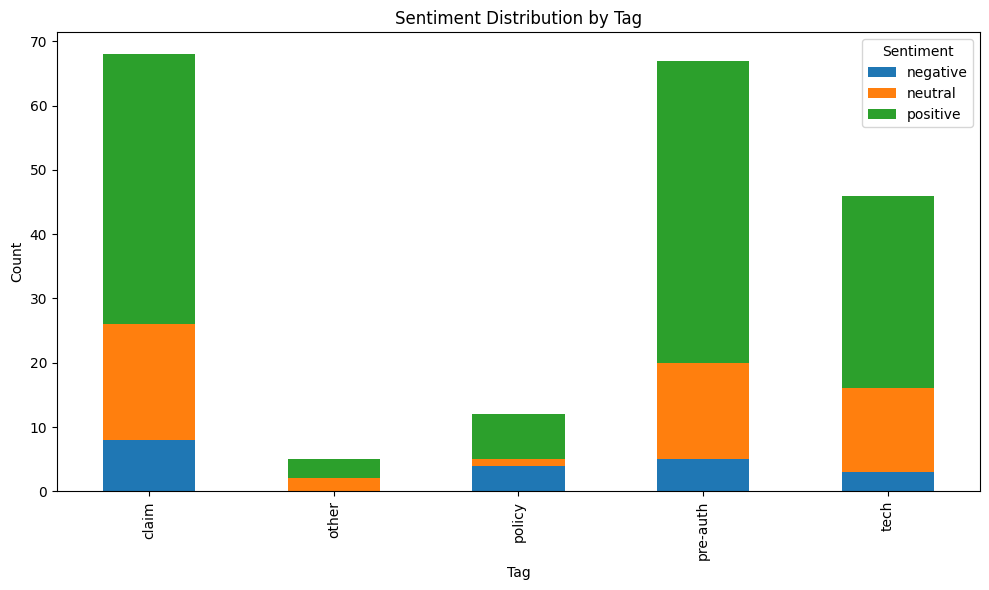

In [60]:
plot_sentiment_distribution(df)

Most transcripts are regarding claims or pre-auth. Claims calls have higher neutral or negative sentiment than pre-auth.

In [61]:
def plot_follow_up_proportion(df):
    """
    Creates a pie chart showing the proportion of follow-up actions by tag.
    """
    follow_up_counts = df[df['follow_up_needed'].str.lower() == 'yes']['tag'].value_counts()
    follow_up_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))

    plt.title("Proportion of Follow-Up Actions by Tag")
    plt.ylabel("")  # Remove y-axis label for clarity
    plt.tight_layout()
    plt.show()

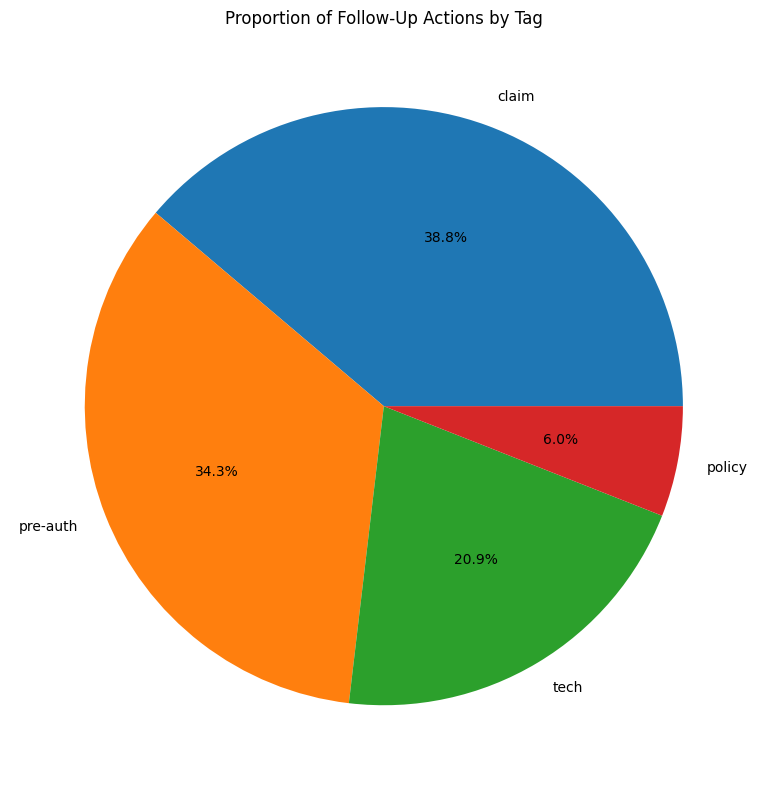

In [62]:
# Call the function
plot_follow_up_proportion(df)

Calls re. claims have highest likelihood of requiring a follow-up. As mentioned preivously, further analysis could be done into exact reason for follow-up and if any processes are hindering a 1 call resolution.

In [63]:
def plot_average_sentiment_by_tag(df):
    """
    Plots a bar chart showing the average sentiment score for each tag.
    """
    sentiment_map = {'negative': 1, 'neutral': 2, 'positive': 3}
    df['sentiment_score'] = df['sentiment'].map(sentiment_map)

    avg_sentiment = df.groupby('tag')['sentiment_score'].mean()
    avg_sentiment.plot(kind='bar', figsize=(8, 6))

    plt.title("Average Sentiment Score by Tag")
    plt.xlabel("Tag")
    plt.ylabel("Average Sentiment Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/zb/g5x4lcv10b16pnz1jhn6gx340000gn/T/ipykernel_76505/410804535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score'] = df['sentiment'].map(sentiment_map)


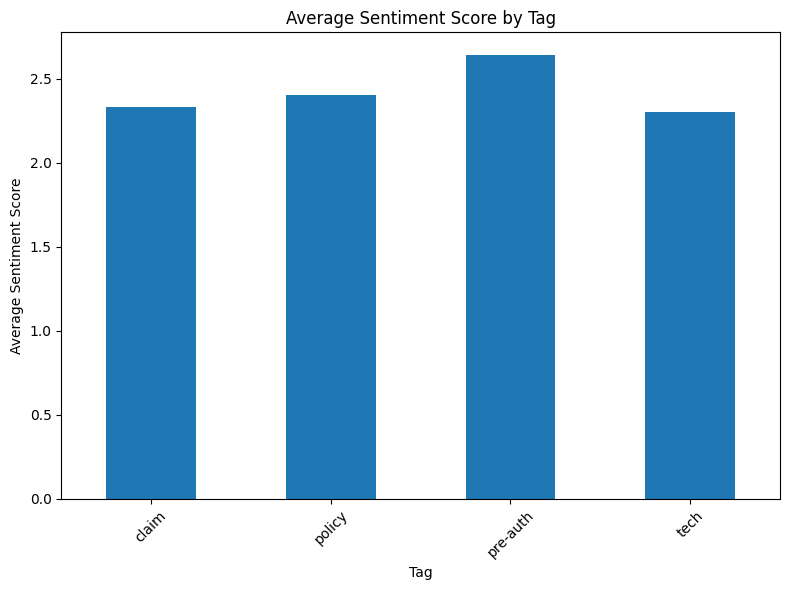

In [64]:
plot_average_sentiment_by_tag(llm_validation_df)

Claims and tech have lowest average sentiment (respectively). "tech" usually involves failed log in to online customer system. This seems like it should be fairly easy to remedy and would be a focus to improve with internal tech teams to see what possible disconnect is - if it is a member issue or if it something that AXA needs to fix.
Sentiment in claims queries may be improved by making policy wording clearer or better advising members on where to find policy documentation. If corporate policies, it may be worth introducing onboarding calls with a broker and insured members to be able to answer questions about what is covered under policy.

In [65]:
def plot_follow_up_by_sentiment(df):
    """
    Plots a stacked bar chart showing follow-up actions for each sentiment.
    """
    follow_up_counts = df.groupby(['sentiment', 'follow_up_needed']).size().unstack(fill_value=0)
    follow_up_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

    plt.title("Follow-Up Actions by Sentiment")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.legend(title="Follow-Up Needed")
    plt.tight_layout()
    plt.show()

In [66]:
def plot_follow_up_by_sentiment(df):
    """
    Plots a stacked bar chart showing follow-up actions for each sentiment,
    and annotates each bar segment with the count of instances.
    """
    follow_up_counts = df.groupby(['sentiment', 'follow_up_needed']).size().unstack(fill_value=0)
    ax = follow_up_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
    for p in ax.patches:
        height = p.get_height()  
        if height > 0:  
            x = p.get_x() + p.get_width() / 2  # Center of the bar segment
            y = p.get_y() + height / 2         # Middle of the bar segment
            ax.text(x, y, f'{int(height)}', ha='center', va='center', fontsize=10, color='black')

    # Add labels and title
    plt.title("Follow-Up Actions by Sentiment")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.legend(title="Follow-Up Needed", labels=["No", "Yes"])
    plt.tight_layout()

    # Show the chart
    plt.show()

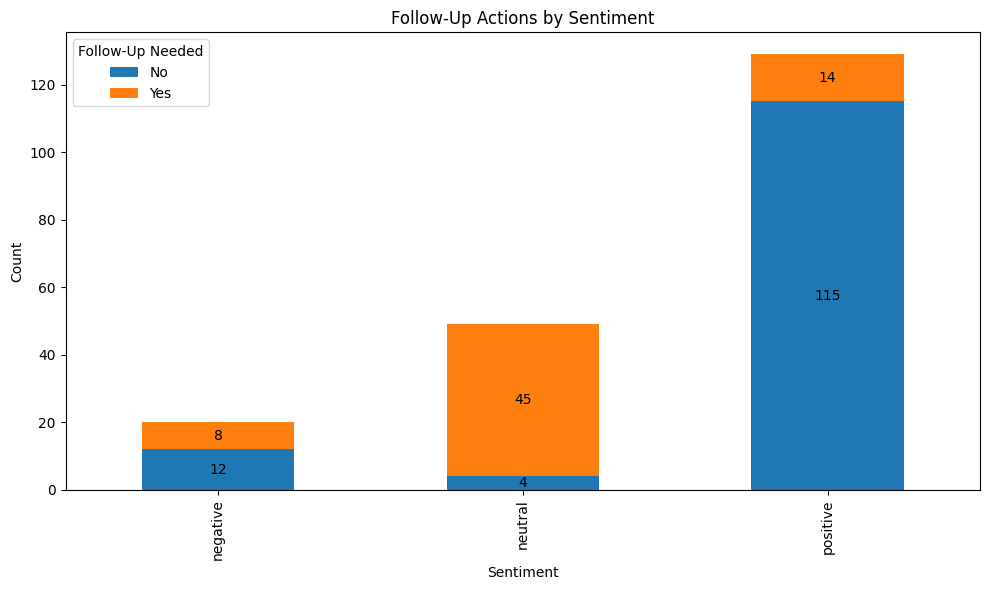

In [67]:
plot_follow_up_by_sentiment(df)

* 40% of negative sentiment calls required a folow-up. 
* 92% of neutral sentiment calls required a follow-up.
* 11% of positive sentiment calls required a follow-up.

The neutral sentiment calls would be an area of focus for me. Could any of these calls have been resolved immediately and possible have led to a positive sentiment from the member? With 89% of positive calls being a 1 call resolution, it is fair to say initiatives that focus on a 1 call resolution would be a step in the right direction.

In [68]:
from wordcloud import WordCloud

In [69]:
def generate_wordcloud_for_negative_sentiment(df):
    """
    Generates a word cloud for transcripts with negative sentiment.
    """
    # Combine all transcripts with negative sentiment
    negative_text = " ".join(df[df['sentiment'].str.lower() == 'negative']['raw'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title("Common Words in Negative Sentiment Transcripts")
    plt.show()

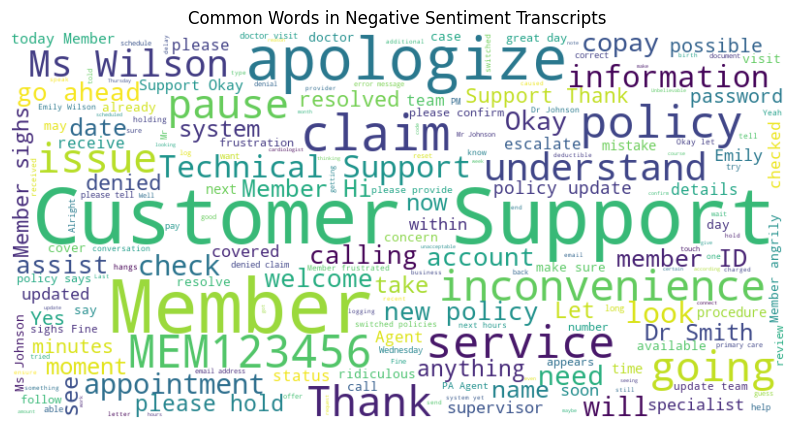

In [70]:
generate_wordcloud_for_negative_sentiment(df)

could regex for certain policy numbers associated with co-pay etc to see if they are frequentrly negative. If a corporate group it could be up to brokers or managers of the contract to decide if benefits are suitable or need to be adjusted

In [71]:
def generate_wordcloud_for_positive_sentiment(df):
    """
    Generates a word cloud for transcripts with positive sentiment.
    """
    # Combine all transcripts with positive sentiment
    positive_text = " ".join(df[df['sentiment'].str.lower() == 'positive']['raw'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')  # Remove axes
    plt.title("Common Words in Positive Sentiment Transcripts", fontsize=15)
    plt.show()

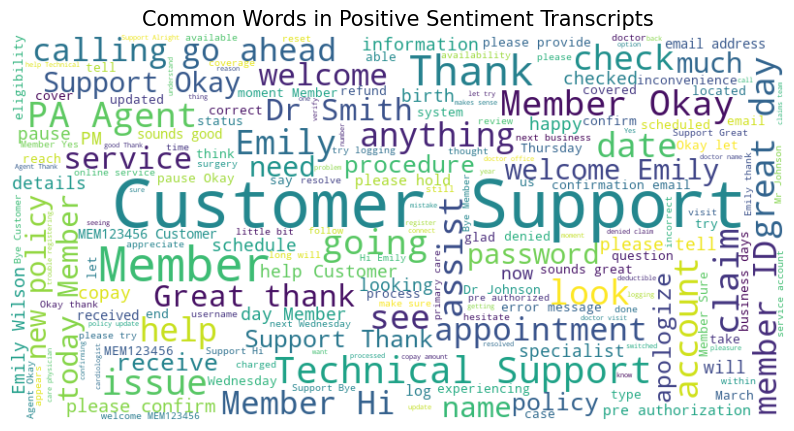

In [72]:
generate_wordcloud_for_positive_sentiment(df)

# Statistical Analyses:
Trying to understand correlation between independent features

### Sentiment Distribution by Tag

In [73]:
import scipy.stats as stats
import seaborn as sns

In [74]:
# Create a contingency table
tag_sentiment_ct = pd.crosstab(df['tag'], df['sentiment'])
# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(tag_sentiment_ct)

In [75]:
print("Chi-Square Test for Tags and Sentiment")
print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")
if p < 0.05:
    print("There is a significant correlation between tags and sentiment.")
else:
    print("No significant correlation between tags and sentiment.")

Chi-Square Test for Tags and Sentiment
Chi2 Statistic: 10.87, p-value: 0.2092
No significant correlation between tags and sentiment.


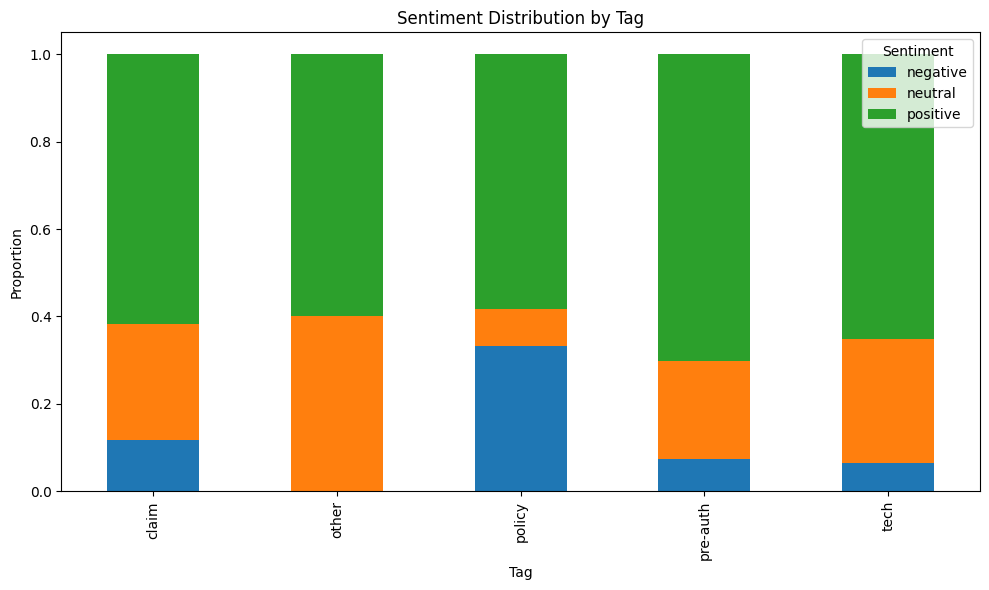

In [76]:
tag_sentiment_dist = tag_sentiment_ct.div(tag_sentiment_ct.sum(axis=1), axis=0)  # Normalize rows
tag_sentiment_dist.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Sentiment Distribution by Tag")
plt.ylabel("Proportion")
plt.xlabel("Tag")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

In terms of proportion of calls, policy has the highest number of negative calls.
Pre-auth generally have most positive sentiment.

### Sentiment Distribution by Follow-up required

In [79]:
follow_up_sentiment_ct = pd.crosstab(df['follow_up_needed'], df['sentiment'])
chi2, p, dof, expected = stats.chi2_contingency(follow_up_sentiment_ct)

In [88]:
print("Chi-Square Test for Follow-Up Needed and Sentiment")
print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")
if p < 0.05:
    print("There is a significant correlation between follow-up needed and sentiment.")
else:
    print("No significant correlation between follow-up needed and sentiment.")

Chi-Square Test for Follow-Up Needed and Sentiment
Chi2 Statistic: 104.40, p-value: 0.0000
There is a significant correlation between follow-up needed and sentiment.


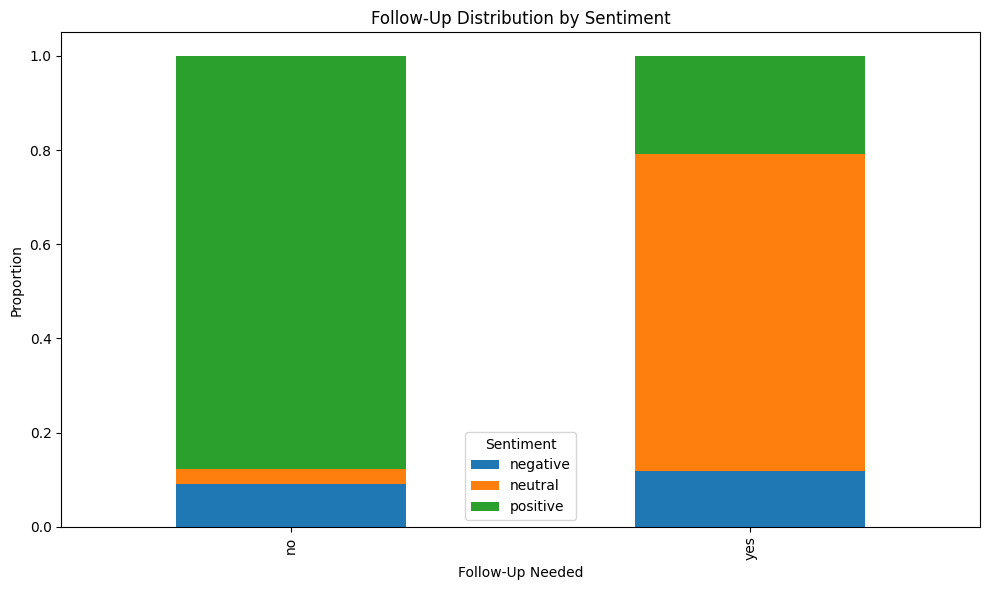

In [81]:
follow_up_sentiment_dist = follow_up_sentiment_ct.div(follow_up_sentiment_ct.sum(axis=1), axis=0)
follow_up_sentiment_dist.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Follow-Up Distribution by Sentiment")
plt.ylabel("Proportion")
plt.xlabel("Follow-Up Needed")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

Large amount of neutral sentiment calls are not resolved within 1 call. Why is this? Worth further investigation. Possibly PA may not have provided a clear resolution, resulting in neutral customer sentiment

## Next steps
* Add additional features like call duration or customer demographics (if available) for further correlation analysis.
* Track changes in sentiment over time to ensure any initiatives introduced can be objectively rated
* If certain tags are driving negative sentiment, deeper analysis into transcripts to identify areas for improvement (e.g., agent training, policy changes).
* Get larger dataset - if any accuracy drops it could raise a case to fine-tune the LLM.
* Better understand from stakeholders where this analysis fits into their projects and how to continuously develop analysis to further support them.